# 1. MODULE-1: Data Pre-Processing

## 1.1 Install Dependencies

In [ ]:
#pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

print ("GPU is","available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU is available


## 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')


In [18]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Collect Positive and Anchor Classes

In [19]:
# Import uuid library to generate unique image names
import uuid

In [20]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/714286ec-f094-11ed-88a5-0242ac1c000c.jpg'

In [24]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(4)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
plt.imshow(frame[120:120+250,200:200+250, :])

## 2.2 Untar Labelled Faces in the Wild Dataset

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [21]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tar

tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [22]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [23]:
!tar -xf an.tgz

tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'


In [24]:
# Move Og anchor Images to the following repository data/anchor
for file in os.listdir('an'):
      EX_PATH = os.path.join('an', file)
      NEW_PATH = os.path.join(ANC_PATH, file)
      os.replace(EX_PATH, NEW_PATH)

In [25]:
# Unzip Positive images collected from webcam
!tar -xf pos.tgz

tar: Ignoring unknown extended header keyword 'SCHILY.fflags'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'


In [26]:
# Move Og positive Images to the following repository data/positive
for file in os.listdir('pos'):
      EX_PATH = os.path.join('pos', file)
      NEW_PATH = os.path.join(POS_PATH, file)
      os.replace(EX_PATH, NEW_PATH)

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [27]:
os.getcwd()

'/content'

In [28]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [29]:
dir_test = anchor.as_numpy_iterator()

In [30]:
print(dir_test.next())

b'data/anchor/815294e6-c09c-11ed-a045-acde48001122.jpg'


## 3.2 Preprocessing - Scale and Resize

---



In [31]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [32]:
img = preprocess('data/anchor/8808d96c-c09c-11ed-a045-acde48001122.jpg')

In [33]:
img.numpy().min() 

0.13308823

In [ ]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [34]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [35]:
samples = data.as_numpy_iterator()

In [36]:
exampple = samples.next()

In [37]:
exampple

(b'data/anchor/85fd4fcc-c09c-11ed-a045-acde48001122.jpg',
 b'data/positive/61ac54e2-c09c-11ed-a045-acde48001122.jpg',
 1.0)

# 2. MODULE-2: Data Partitioning

## 2.1 Build Train and Test Partition

In [38]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [39]:
res = preprocess_twin(*exampple)

In [40]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.95392156, 0.9382353 , 0.89509803],
         [0.9529412 , 0.9372549 , 0.8960784 ],
         [0.9578431 , 0.93333334, 0.9009804 ],
         ...,
         [0.93333334, 0.92058825, 0.90294117],
         [0.9362745 , 0.92058825, 0.90882355],
         [0.9372549 , 0.92156863, 0.9098039 ]],
 
        [[0.9502451 , 0.9384804 , 0.90318626],
         [0.9468137 , 0.9343137 , 0.8990196 ],
         [0.9490196 , 0.9343137 , 0.8990196 ],
         ...,
         [0.93357843, 0.9218137 , 0.9022059 ],
         [0.9372549 , 0.9232843 , 0.9080882 ],
         [0.9372549 , 0.92156863, 0.9098039 ]],
 
        [[0.95098037, 0.93921566, 0.90392154],
         [0.95612746, 0.94436276, 0.90906864],
         [0.9558824 , 0.94191176, 0.90661764],
         ...,
         [0.9372549 , 0.9254902 , 0.9014706 ],
         [0.935049  , 0.9232843 , 0.90367645],
         [0.9372549 , 0.9245098 , 0.90686274]],
 
        ...,
 
        [[0.37230393, 0.38406864

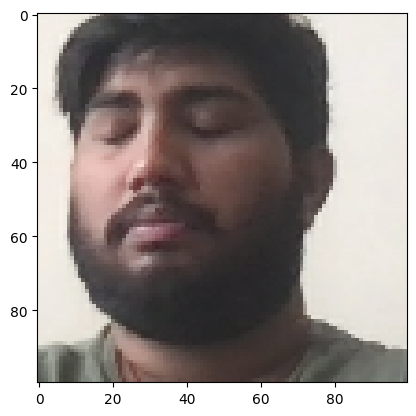

In [41]:
plt.imshow(res[0])

In [42]:
res[2]

1.0

In [43]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [44]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 3. MODULE-3: Facial Extraction - Model Engineering

## 3.1 Build Embedding Layer

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [ ]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [ ]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [ ]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [ ]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

In [7]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [8]:
embedding = make_embedding()

In [46]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 3.2 Build Distance Layer

In [9]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [10]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding, validation_embedding)

## 3.3 Make TNN Model

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
TNN_layer = L1Dist()

In [ ]:
distances = TNN_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [ ]:
TNN_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
TNN_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_4 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [11]:
def make_TNN_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine TNN distance components
    TNN_layer = L1Dist()
    TNN_layer._name = 'distance'
    distances = TNN_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [12]:
TNN_model = make_TNN_model()

In [48]:
TNN_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# MODULE-4: Training

## 4.1 Setup Loss and Optimizer

In [49]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [50]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 4.2 Establish Checkpoints

In [56]:
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=TNN_model)

## 4.3 Build Train Step Function

In [57]:
test_batch = train_data.as_numpy_iterator()

In [59]:
batch_1 = test_batch.next()

In [60]:
X = batch_1[:2]

In [61]:
y = batch_1[2]

In [62]:
y

array([0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

In [71]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = TNN_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, TNN_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, TNN_model.trainable_variables))
        
    # Return loss
    return loss

## 4.4 Build Training Loop

In [63]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [72]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = TNN_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 4.5 Model Training

In [70]:
EPOCHS = 20

In [73]:
train(train_data, EPOCHS)


 Epoch 1/20
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
26/26 [==============================] - 22s 365ms/step
0.23042734 0.4162896 1.0

 Epoch 2/20
26/26 [==============================] - 8s 313ms/step
0.07615878 0.980198 0.99

 Epoch 3/20
26/26 [==============================] - 8s 303ms/step
0.12500012 0.995283 1.0

 Epoch 4/20
26/26 [==============================] - 8s 298ms/step
0.04582721 1.0 1.0

 Epoch 5/20
26/26 [==============================] - 7s 283ms/step
0.21795952 0.7294686 0.9805195

 Epoch 6/20
26/26 [==============================] - 8s 295ms/step
0.1101895 0.9766355 0.99523807

 Epoch 7/20
26/26 [==============================] - 8s 291ms/step
0.009750974 0.99033815 1.0

 Epoch 8/20
26/26 [==============================] - 7s 267ms/step
0.00020462228 0.99523807 0.99523807

 Epoch 9/20
26/26 [==============================] - 7s 284ms/step
0.084654406 0.9

# 4.6 Model Saving

In [74]:
# Save weights
TNN_model.save('TNNModelv2.h5')

In [75]:
L1Dist

__main__.L1Dist

In [77]:
# Reload model 
TNN_model = tf.keras.models.load_model('/content/TNNModelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [81]:
# Make predictions with reloaded model
TNN_model.predict([test_input, test_val])

NameError: ignored

In [80]:
# View model summary
TNN_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# MODULE-5: Evaluation

## 5.1 Import Metrics

In [82]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 5.2 Make Predictions

In [83]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [84]:
y_hat = TNN_model.predict([test_input, test_val])
#y_hat

1/1 [==============================] - 0s 195ms/step


In [85]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0]

In [86]:
y_true

array([0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0.],
      dtype=float32)

## 5.3 Calculate Metrics

In [87]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [88]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [90]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = TNN_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 1s 529ms/step
1.0 1.0


## 5.4 Visualizing Results

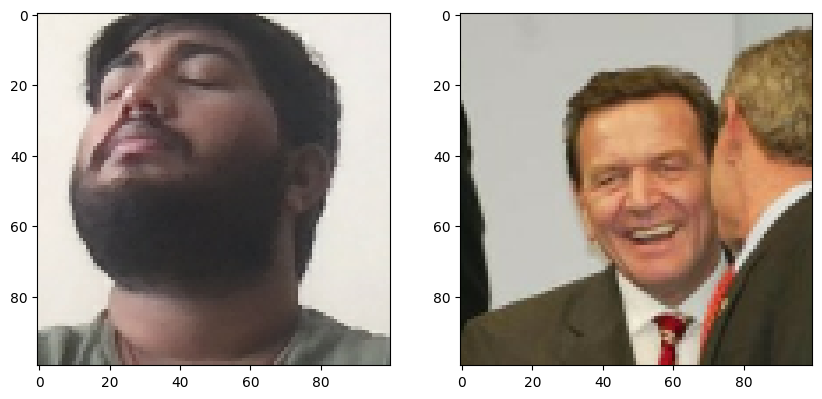

In [91]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

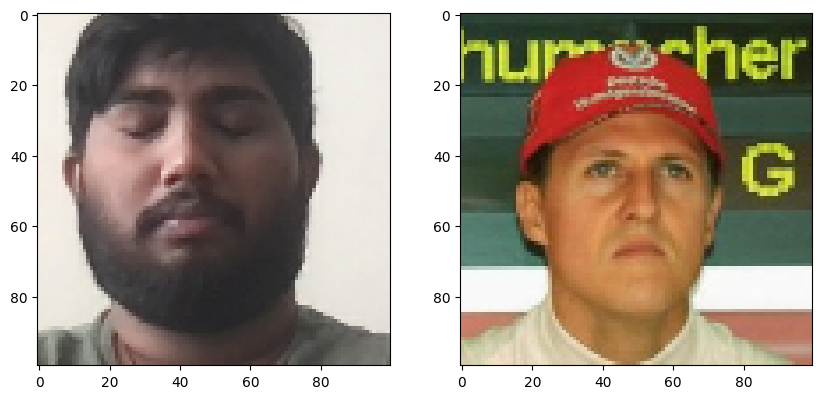

In [93]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

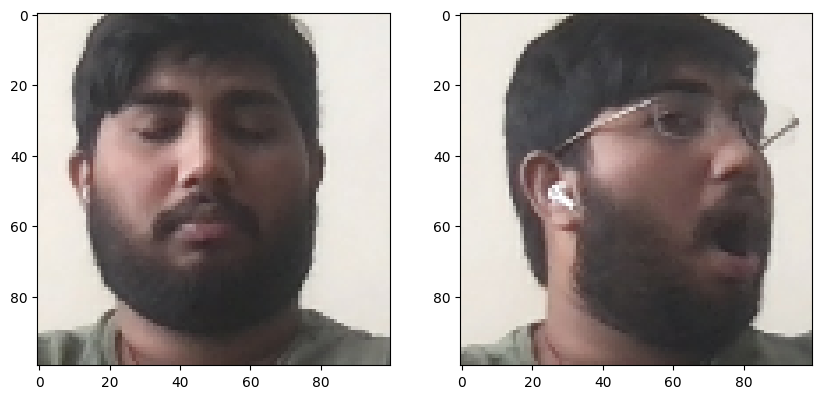

In [95]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

# Renders cleanly
plt.show()

# MODULE-6: Video Detection

## 6.1 Face Detection

In [ ]:
import cv2, time
from matplotlib import pyplot as plt
from tkinter import *
window=Tk()	

def videoFaceDet():

	
	video = cv2.VideoCapture("face-video-1.mov")	# _video_file_path
	faceCascade=cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
	while True:
		
		check, frame = video.read()
		
		
		grayImg=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
		plt.imshow(grayImg)

		#This is the crux of the program where discretionary parameters can be set for better results
		
		#The Scalefactor decides how many iterations the Classifier will perform in its seach for images. 
		#In every iteration, the Classifier looks for a bigger face size, starting from small and going up
		#until it is checking the entire size of the frame. The scaleFactor decides this step size. 
		#Smaller the scaleFactor, more sensitive the Classifier and longer it takes to process the frame
		
		#The minNeighbors decides the Parameter specifying how many neighbors each candidate rectangle should have to retain it.
		#Greater the minNeighbors, greater the sensitivity. However, higher might lead to false positives.
		
		#The detectMultiScale returns a list of (set of) values that can be used to build a rectangle as shown below
		faces=faceCascade.detectMultiScale(grayImg, scaleFactor=1.05, minNeighbors=5)
		
		#superimposes a rectangle for all the detected images in the frame
		#(x,y) is the top left corner, (x+w, y+h) is the bottom right corner
		#(0,255,0) is colour green and 3 is the thickness of the rectangle edges
		for x, y, w, h in faces:
			frame=cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 3)
		#window displaying the processed image
		cv2.imshow("Capturing", frame)

		#picks up the key press Q and exits when pressed
		key=cv2.waitKey(1)
		if key==ord('q'):
			break
	
	#Closes video window
	cv2.destroyAllWindows()
	
	#releases the video feed from the webcam/file
	video.release()
 
 #End of the function

In [ ]:
#  #running of the function

#GUI tkinter button for starting the video capture
b1=Button(window, text="Start", command=videoFaceDet)
b1.grid(row=0, column=0)

#GUI widget label
l1=Label(window, text="Press Q to Stop Capturing")
l1.grid(row=0, column=1)

#close GUI Window
window.mainloop()

## 6.2 Image Rescaling

In [ ]:
def vid_input():
  cap = cv2.VideoCapture('_video_file_path.mov')
  prev_verified = None  # Initialize previous verification status
  while cap.isOpened():
      ret, frame = cap.read()
      if not ret:  # If no frame is retrieved, break the loop
          break
      frame = frame[200:200+250,500:500+250, :]
      
      cv2.imshow('Verification', frame)
      
      # Verification trigger
      cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
          # Run verification
      results, verified = verify(siamese_model, 0.5, 0.5)
     
      
      #to print it once throughout the video, rather than continously on the screen
      if prev_verified is None:  # If first iteration, print the initial status
          print('Verified' if verified else 'Not verified')
      elif prev_verified != verified:  # If status has changed, print the new status
          print('Verified' if verified else 'Not verified')
      prev_verified = verified
      
      if cv2.waitKey(10) & 0xFF == ord('q'):
          break
  cap.release()
  cv2.destroyAllWindows()

# MODULE-7: Face Recognition

## 7.1: Tnn Face Recognition

## 7.1.1: Verification Images

In [96]:
#application_data\verification_images
#extract 50 images for application data
ver_path = os.path.join('application_data', 'verification_images')
!tar -xf 50.tgz
# Move Og anchor Images to the following repository data/anchor
for file in os.listdir('50'):
      EX_PATH = os.path.join('50', file)
      NEW_PATH = os.path.join(ver_path, file)
      os.replace(EX_PATH, NEW_PATH)

In [97]:
os.listdir(os.path.join('application_data', 'verification_images'))

['f2ffc31c-c09b-11ed-a045-acde48001122.jpg',
 'ec1bc870-c09b-11ed-a045-acde48001122.jpg',
 'f50b9690-c09b-11ed-a045-acde48001122.jpg',
 'f4d8a67c-c09b-11ed-a045-acde48001122.jpg',
 'f15a0b6c-c09b-11ed-a045-acde48001122.jpg',
 'e4dc1b96-c09b-11ed-a045-acde48001122.jpg',
 'ec818584-c09b-11ed-a045-acde48001122.jpg',
 'f64bfebe-c09b-11ed-a045-acde48001122.jpg',
 'ebe8f80a-c09b-11ed-a045-acde48001122.jpg',
 'e4439bf0-c09b-11ed-a045-acde48001122.jpg',
 'efb3e7f6-c09b-11ed-a045-acde48001122.jpg',
 'f53e5c2e-c09b-11ed-a045-acde48001122.jpg',
 'e4a8df6a-c09b-11ed-a045-acde48001122.jpg',
 'eaa87632-c09b-11ed-a045-acde48001122.jpg',
 'f1bf9dce-c09b-11ed-a045-acde48001122.jpg',
 'ec4e9836-c09b-11ed-a045-acde48001122.jpg',
 'f6e4045c-c09b-11ed-a045-acde48001122.jpg',
 'f47311c2-c09b-11ed-a045-acde48001122.jpg',
 'f18c9140-c09b-11ed-a045-acde48001122.jpg',
 'f3982cce-c09b-11ed-a045-acde48001122.jpg',
 'e9dd4246-c09b-11ed-a045-acde48001122.jpg',
 'f6b177c6-c09b-11ed-a045-acde48001122.jpg',
 'ef34e01e

In [98]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [99]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/f2ffc31c-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/ec1bc870-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/f50b9690-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/f4d8a67c-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/f15a0b6c-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/e4dc1b96-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/ec818584-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/f64bfebe-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/ebe8f80a-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/e4439bf0-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/efb3e7f6-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/f53e5c2e-c09b-11ed-a045-acde48001122.jpg
application_data/verification_images/e4a8df6a-c09b-11ed-a045-acd

In [122]:
results = []

In [123]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [ ]:
from google.colab import files
files.download('/content/TNNModelv2.h5')

In [152]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [156]:
!ffmpeg -i vid-3.mov -c:v copy -c:a copy output.mp4

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [165]:
!ls

50	an.tgz		  lfw	   pos.tgz	  training_checkpoints	w.jpg
50.tgz	application_data  lfw.tar  sample_data	  vid-3.mov		w.mp4
an	data		  pos	   TNNModelv2.h5  vid-3.mp4


In [168]:
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('vid-3.mp4')

ret, frame = cap.read()
if ret == False:
  print("true")
frame = frame[200:200+250,400:400+250, :]
cv2_imshow(frame)

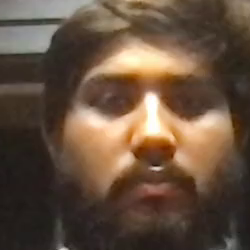

In [169]:
frame = frame[200:200+250,400:400+250, :]
cv2_imshow(frame)

In [162]:
#original version, with web-cam
cap = cv2.VideoCapture('/content/vid-3.mp4')
while cap.isOpened():
    # print("inside")
    ret, frame = cap.read()
    frame = frame[200:200+250,420:420+250, :]
    
    #cv2.imshow('Verification', frame)
    
    # Verification trigger
    cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
    results, verified = verify(TNN_model, 0.9, 0.7)
    print(verified)
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         # Save input image to application_data/input_image folder 
# #         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# #         h, s, v = cv2.split(hsv)
 
# #         lim = 255 - 10
# #         v[v > lim] = 255
# #         v[v <= lim] -= 10
        
# #         final_hsv = cv2.merge((h, s, v))
# #         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         #Run verification
#         results, verified = verify(siamese_model, 0.5, 0.5)
#         print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 19ms/step
True
1/1 [==============================] - 0s 33ms/step
True
1/1 [==============================] - 0s 22ms/step
True
1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 19ms/step
True
1/1 [==============================] - 0s 22ms/step
True
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 27ms/step
True
1/1 [==============================] - 0s 22ms/step
True
1/1 [==============================] - 0s 21ms/step
True
1/1 [==============================] - 0s 34ms/step
True
1/1 [==============================] - 0s 18ms/step
True
1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 20ms/step
True
1/1 [==============================] - 0s 29ms/step
True
1/1 [==========================

KeyboardInterrupt: ignored

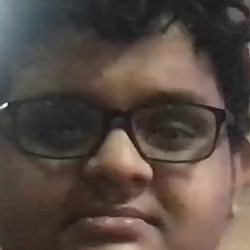

In [177]:
from google.colab.patches import cv2_imshow
cap = cv2.VideoCapture('vid-4.mp4')

ret, frame = cap.read()
if ret == False:
  print("true")
frame = frame[200:200+250,400:400+250, :]
cv2_imshow(frame)

In [178]:
#original version, with web-cam
cap = cv2.VideoCapture('/content/vid-4.mp4')
while cap.isOpened():
    # print("inside")
    ret, frame = cap.read()
    frame = frame[200:200+250,420:420+250, :]
    
    #cv2.imshow('Verification', frame)
    
    # Verification trigger
    cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
    results, verified = verify(TNN_model, 0.9, 0.7)
    print(verified)
#     if cv2.waitKey(10) & 0xFF == ord('v'):
#         # Save input image to application_data/input_image folder 
# #         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
# #         h, s, v = cv2.split(hsv)
 
# #         lim = 255 - 10
# #         v[v > lim] = 255
# #         v[v <= lim] -= 10
        
# #         final_hsv = cv2.merge((h, s, v))
# #         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

#         cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
#         #Run verification
#         results, verified = verify(siamese_model, 0.5, 0.5)
#         print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
False
1/1 [==============================] - 0s 36ms/step
False
1/1 [==============================] - 0s 31ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 38ms/step
False
1/1 [==============================] - 0s 21ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 36ms/step
False
1/1 [==============================] - 0s 24ms/step
False
1/1 [==============================] - 0s 24ms/step
False
1/1 [==============================] - 0s 30ms/step
False
1/1 [==============================] - 0s 21ms/step
False
1/1 [==============================] - 0s 23ms/step
False
1/1 [==============================] - 0s 34ms/step
False
1/1 [==============================] - 0s 22ms/step
False
1/1 [==============================] - 0s 20ms/step
False
1/1 [==============================] - 0s 43ms/step


KeyboardInterrupt: ignored

In [114]:
# using video, it takes each frame and verifies it
cap = cv2.VideoCapture('vid-3.mov')
prev_verified = None  # Initialize previous verification status
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:  # If no frame is retrieved, break the loop
        break
    frame = frame[200:200+250,420:420+250, :]
    
    #cv2.imshow('Verification', frame)
    
    # Verification trigger
    cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
    results, verified = verify(TNN_model, 0.5, 0.5)
    #simple print statment to print it constantly through out the video
    #print(verified)
    #to print it once throughout the video, rather than continously on the screen
    if prev_verified is None:  # If first iteration, print the initial status
        print('Verified' if verified else 'Not verified')
    elif prev_verified != verified:  # If status has changed, print the new status
        print('Verified' if verified else 'Not verified')
    prev_verified = verified
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [125]:
np.sum(np.squeeze(results) > 0.9)

0

In [126]:
results

[]